<a href="https://colab.research.google.com/github/decoderkurt/HUF_RL_2022/blob/main/22/sb3_ppo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [15]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [2]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [3]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libglew-dev is already the newest version (2.0.0-5).
libgl1-mesa-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
libgl1-mesa-glx is already the newest version (20.0.8-0ubuntu1~18.04.1).
libosmesa6-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
software-properties-common is already the newest version (0.96.24.32.18).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
patchelf is already the newest version (0.9-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [4]:
!pip install free-mujoco-py

In [5]:
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

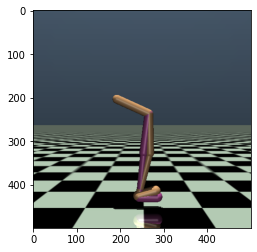

In [5]:
env = wrap_env(gym.make("Walker2d-v2"))
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(50):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')
  
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break
    
ipythondisplay.clear_output(wait=True)
env.close()


In [2]:
!apt install swig cmake
!pip install stable-baselines3[extra] box2d box2d-kengz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
cmake is already the newest version (3.10.2-1ubuntu2.18.04.2).
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 1s (1,270 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 155229 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-1_amd64.deb ...
Unpacking swig3.0 (3.0.12-1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_3.0.12-1_amd64.deb ...
Unpackin

In [6]:
import os

import gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import TD3
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback

In [11]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print(f"Saving new best model to {self.save_path}.zip")
                  self.model.save(self.save_path)

        return True

In [7]:
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make('LunarLanderContinuous-v2')
# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)

In [8]:
# Create action noise because TD3 and DDPG use a deterministic policy
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
# Create RL model
model = TD3('MlpPolicy', env, action_noise=action_noise, verbose=0)
# Train the agent
model.learn(total_timesteps=int(5e4), callback=callback)

NameError: ignored

In [10]:
import gym
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

env_id = 'CartPole-v1'
video_folder = 'video/'
video_length = 100

env = DummyVecEnv([lambda: gym.make(env_id)])

obs = env.reset()

# Record the video starting at the first step
env = VecVideoRecorder(env, video_folder,
                       record_video_trigger=lambda x: x == 0, video_length=video_length,
                       name_prefix=f"random-agent-{env_id}")

env.reset()
for _ in range(video_length + 1):
  action = [env.action_space.sample()]
  obs, _, _, _ = env.step(action)
# Save the video
env.close()

show_video()

Saving video to /content/video/random-agent-CartPole-v1-step-0-to-step-100.mp4


In [34]:
import os

import gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback

# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make('Humanoid-v2')
# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)

# Create action noise because TD3 and DDPG use a deterministic policy
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
# Create RL model
model = PPO('MlpPolicy', env)
# Train the agent
model.learn(total_timesteps=int(5e4), callback=callback)

Compiling /usr/local/lib/python3.7/dist-packages/mujoco_py/cymj.pyx because it changed.
[1/1] Cythonizing /usr/local/lib/python3.7/dist-packages/mujoco_py/cymj.pyx
running build_ext
building 'mujoco_py.cymj' extension
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuextensionbuilder
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuextensionbuilder/temp.linux-x86_64-3.7
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuextensionbuilder/temp.linux-x86_64-3.7/usr
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuextensionbuilder/temp.linux-x86_64-3.7/usr/local
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuextensionbuilder/temp.linux-x86_64-3.7/usr/local/lib
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuexten

In [35]:
import gym
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
from stable_baselines3 import PPO

env_id = 'Humanoid-v2'
video_folder = 'video/'
video_length = 10000

env = DummyVecEnv([lambda: gym.make(env_id)])



# Record the video starting at the first step
env = VecVideoRecorder(env, video_folder,
                       record_video_trigger=lambda x: x == 0, video_length=video_length,
                       name_prefix=f"ppo-agent-{env_id}")

obs =  model.env.reset()

# Evaluate the agent
episode_reward = 0
for _ in range(video_length):
    action,_ = model.predict(obs)
    obs, reward, done, info =  model.env.step(action)
    model.env.render()
    episode_reward += reward
    if done:
        print("Reward:", episode_reward)
        episode_reward = 0.0
        obs = model.env.reset()

Creating window glfw
Reward: [99.53571]
Reward: [152.60625]
Reward: [198.72139]
Reward: [170.69836]
Reward: [264.3679]
Reward: [210.99724]
Reward: [173.42934]
Reward: [441.24756]
Reward: [181.72458]
Reward: [111.72015]
Reward: [98.59617]
Reward: [227.10934]
Reward: [243.34592]
Reward: [115.89685]
Reward: [206.91501]
Reward: [323.24753]
Reward: [201.55887]
Reward: [317.5675]
Reward: [81.42965]
Reward: [193.64748]
Reward: [366.7321]
Reward: [235.17863]
Reward: [254.6096]
Reward: [183.76872]
Reward: [212.78725]
Reward: [264.9263]
Reward: [240.84956]
Reward: [96.86635]
Reward: [245.50229]
Reward: [284.83542]
Reward: [286.45547]
Reward: [158.48059]
Reward: [242.79034]
Reward: [143.43393]
Reward: [183.90625]
Reward: [218.74667]
Reward: [215.38498]
Reward: [197.75426]
Reward: [273.87592]
Reward: [207.32837]
Reward: [208.27753]
Reward: [338.15802]
Reward: [214.45865]
Reward: [182.2625]
Reward: [225.45099]
Reward: [164.42421]
Reward: [279.533]
Reward: [356.5016]
Reward: [217.88626]
Reward: [141

In [36]:
show_video()

Could not find video
